In [43]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

[*********************100%***********************]  1 of 1 completed


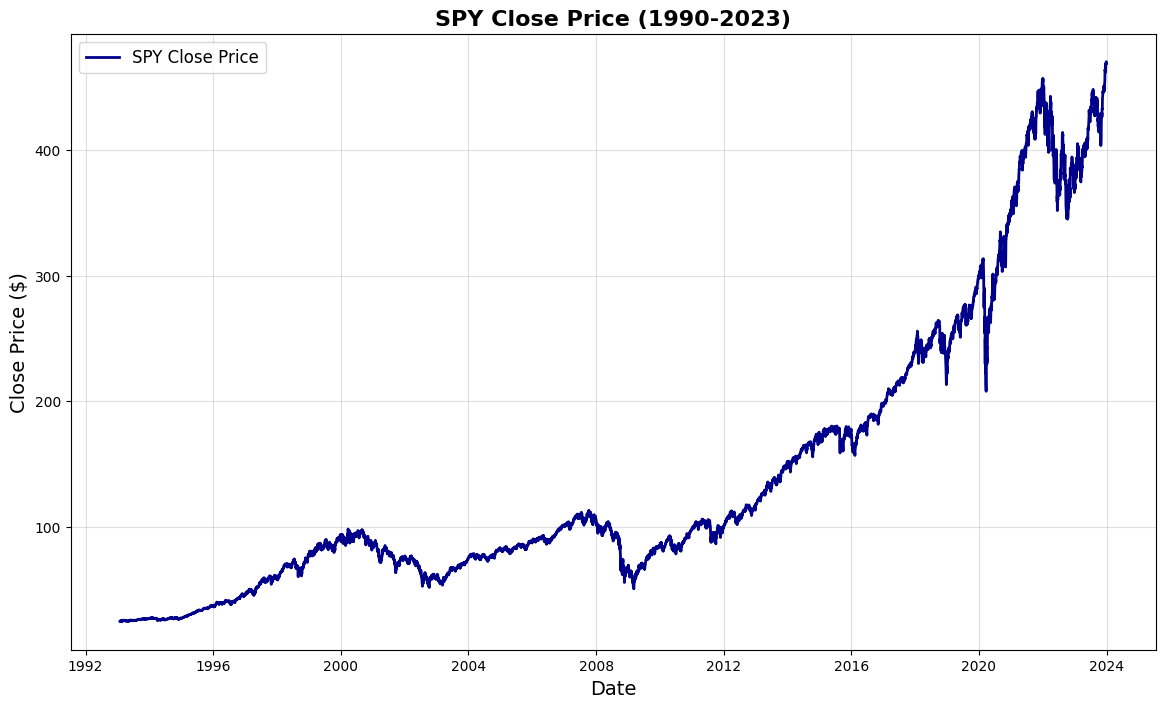

In [44]:
data = yf.download("SPY", start="1990-01-01", end="2023-12-31")
data.columns = data.columns.get_level_values(0)
data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label='SPY Close Price', color='darkblue', linewidth=2)

# Add title and labels
plt.title("SPY Close Price (1990-2023)", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price ($)", fontsize=14)

# Enhance grid and legend
plt.grid(alpha=0.4)
plt.legend(fontsize=12)

# Display plot
plt.show()

In [45]:
# Calculate the percentage change in closing price compared to the previous day
data["% Change"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)

# Create a target variable: 1 if the next day's % change is positive, 0 otherwise
data["Target"] = (data["% Change"].shift(-1) > 0).astype(int)

# Calculate moving averages for 10, 50, and 200 days
data["10-Day MA"] = data["Close"].rolling(window=10).mean()  # 10-day moving average
data["50-Day MA"] = data["Close"].rolling(window=50).mean()  # 50-day moving average
data["200-Day MA"] = data["Close"].rolling(window=200).mean()  # 200-day moving average

# Calculate relative differences between moving averages and closing price
data["Rel_MA_Diff_10_50"] = (data["10-Day MA"] - data["50-Day MA"]) / data["Close"]  # Relative difference between 10-day and 50-day MA
data["Rel_MA_Diff_50_200"] = (data["50-Day MA"] - data["200-Day MA"]) / data["Close"]  # Relative difference between 50-day and 200-day MA

# Calculate the price's distance from moving averages as a percentage
data["Price_Dist_10"] = (data["Close"] - data["10-Day MA"]) / data["Close"]  # Price distance from 10-day MA
data["Price_Dist_50"] = (data["Close"] - data["50-Day MA"]) / data["Close"]  # Price distance from 50-day MA
data["Price_Dist_200"] = (data["Close"] - data["200-Day MA"]) / data["Close"]  # Price distance from 200-day MA

# Generate crossover signals: 1 if the shorter MA is above the longer MA, otherwise 0
data["Crossover_10_50"] = (data["10-Day MA"] > data["50-Day MA"]).astype(int)  # 10-day MA crosses above 50-day MA
data["Crossover_50_200"] = (data["50-Day MA"] > data["200-Day MA"]).astype(int)  # 50-day MA crosses above 200-day MA

# Calculate Exponential Moving Averages (EMAs) with spans of 12 and 26
data["EMA_12"] = data["Close"].ewm(span=12, adjust=False).mean()  # 12-day EMA
data["EMA_26"] = data["Close"].ewm(span=26, adjust=False).mean()  # 26-day EMA

# Compute the MACD (Moving Average Convergence Divergence) line
data["MACD"] = data["EMA_12"] - data["EMA_26"]

# Calculate the signal line for MACD (9-day EMA of the MACD)
data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()

# Generate MACD signal: 1 if MACD is above the Signal Line, 0 otherwise
data["MACD_Signal"] = (data["MACD"] > data["Signal_Line"]).astype(int)

# Drop intermediate EMA, MACD, Signal_Line columns to save space (optional)
data.drop(columns=["EMA_12", "EMA_26", "MACD", "Signal_Line"], inplace=True)

# Calculate the Relative Strength Index (RSI)
delta = data["Close"].diff()  # Daily price changes
gain = (delta.where(delta > 0, 0)).rolling(window=2).mean()  # Average gain over 2 days
loss = (-delta.where(delta < 0, 0)).rolling(window=2).mean()  # Average loss over 2 days
rs = gain / loss  # Relative strength
rsi = 100 - (100 / (1 + rs))  # RSI formula
data["RSI"] = rsi  # Add RSI to the dataset

# Generate RSI signal: 1 for oversold, -1 for overbought, 0 for neutral
data["RSI_Signal"] = 0  # Initialize to 0
data.loc[data["RSI"] > 90, "RSI_Signal"] = -1  # RSI > 90 indicates overbought (negative signal)
data.loc[data["RSI"] < 10, "RSI_Signal"] = 1  # RSI < 10 indicates oversold (positive signal)

# Drop rows with NaN values introduced by rolling calculations
data.dropna(inplace=True)


In [46]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    pred = model.predict_proba(test[predictors])[:, 1]
    threshold = 0.45
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    pred = pd.Series(pred, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], pred], axis=1)
    return combined

In [47]:
def backtest(data, predictors, model, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [48]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

predictors = ["% Change", "Rel_MA_Diff_10_50", "Rel_MA_Diff_50_200", "Price_Dist_10", "Price_Dist_50", "Price_Dist_200", "Crossover_10_50", "Crossover_50_200", "RSI_Signal"]
preds = backtest(data, predictors, model)

In [49]:
preds["% Change"] = data["% Change"]
preds["Cumulative Return"] = (1 + preds["% Change"]).cumprod().copy()
preds["RSI_Signal"] = data["RSI_Signal"]
preds["Value"] = (10000 * preds["Cumulative Return"])
preds["Crossover_10_50"] = data["Crossover_10_50"]
preds["Crossover_50_200"] = data["Crossover_50_200"]
preds["MACD_Signal"] = data["MACD_Signal"]

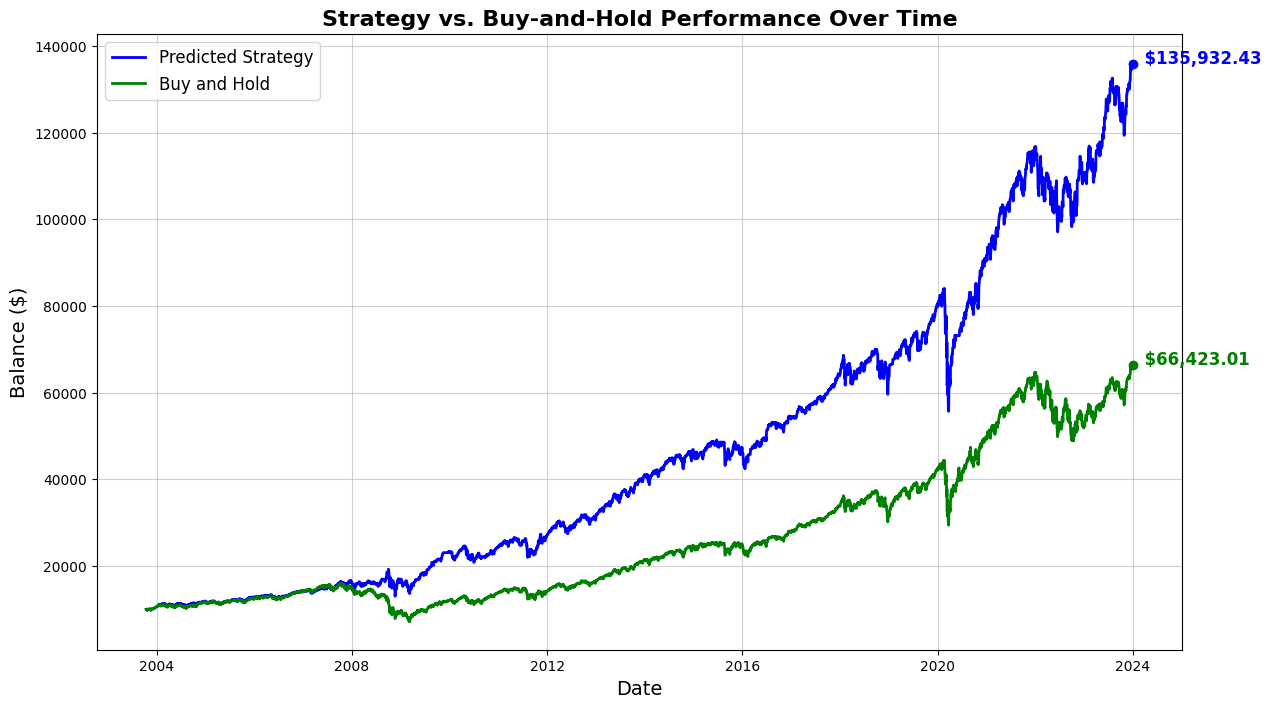

In [50]:
# Calculate balances over time
initial_balance = 10000  # Starting with $10,000
balance_predictions = initial_balance
balance_buy_hold = initial_balance

# Lists to store balances over time
predicted_balances = [initial_balance]
buy_hold_balances = [initial_balance]

# Loop through the DataFrame to calculate balances
for i in range(len(preds) - 1):  # Exclude the last row since we use i + 1
    # Predicted strategy
    if ((preds["Predictions"].iloc[i] == 1) &
        ~((preds["Crossover_50_200"].iloc[i] == 0) &
          (preds["RSI_Signal"].iloc[i] == -1))):
        balance_predictions *= (1 + preds["% Change"].iloc[i + 1])
    
    # Append to predicted balances
    predicted_balances.append(balance_predictions)

    # Buy-and-hold strategy
    balance_buy_hold *= (1 + preds["% Change"].iloc[i + 1])
    buy_hold_balances.append(balance_buy_hold)

# Add calculated balances to DataFrame
preds["Predicted_Balance"] = predicted_balances
preds["Buy_Hold_Balance"] = buy_hold_balances

# Plot the entire time period
plt.figure(figsize=(14, 8))
plt.plot(preds.index, preds["Predicted_Balance"], label="Predicted Strategy", color="blue", linewidth=2)
plt.plot(preds.index, preds["Buy_Hold_Balance"], label="Buy and Hold", color="green", linewidth=2)

# Add final balance annotations
final_predicted_balance = predicted_balances[-1]
final_buy_hold_balance = buy_hold_balances[-1]
plt.scatter(preds.index[-1], final_predicted_balance, color="blue", zorder=5)
plt.text(preds.index[-1], final_predicted_balance, f"  ${final_predicted_balance:,.2f}", color="blue", fontsize=12, ha='left', weight='bold')
plt.scatter(preds.index[-1], final_buy_hold_balance, color="green", zorder=5)
plt.text(preds.index[-1], final_buy_hold_balance, f"  ${final_buy_hold_balance:,.2f}", color="green", fontsize=12, ha='left', weight='bold')

plt.title("Strategy vs. Buy-and-Hold Performance Over Time", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Balance ($)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)
plt.show()


In [51]:
# Count growth and decline days in the real S&P 500 data
count_growth = (preds["Target"] == 1).sum()
count_decline = (preds["Target"] == 0).sum()

print("\nMarket Summary")
print("-" * 30)
print(f"Days of Growth: {count_growth}")
print(f"Days of Decline: {count_decline}")

# Calculate true positives, true negatives, false positives, and false negatives for the algorithm's predictions
true_positive_model = ((preds["Target"] == 1) & (preds["Predictions"] == 1)).sum()
true_negative_model = ((preds["Target"] == 0) & (preds["Predictions"] == 0)).sum()
false_positive_model = ((preds["Target"] == 0) & (preds["Predictions"] == 1)).sum()
false_negative_model = ((preds["Target"] == 1) & (preds["Predictions"] == 0)).sum()

(preds["Predictions"] == 1) & ~((preds["Crossover_50_200"] == 0) & (preds["RSI_Signal"] == -1))

# Calculate true positives, true negatives, false positives, and false negatives for the algorithm's actions (buy signals)
true_positive_action = (((preds["Predictions"] == 1) & ~((preds["Crossover_50_200"] == 0) & (preds["RSI_Signal"] == -1))) & (preds["Target"] == 1)).sum()
true_negative_action = (((preds["Predictions"] == 0) | ((preds["Crossover_50_200"] == 0) & (preds["RSI_Signal"] == -1))) & (preds["Target"] == 0)).sum()
false_positive_action = (((preds["Predictions"] == 1) & ~((preds["Crossover_50_200"] == 0) & (preds["RSI_Signal"] == -1))) & (preds["Target"] == 0)).sum()
false_negative_action = (((preds["Predictions"] == 0) | ((preds["Crossover_50_200"] == 0) & (preds["RSI_Signal"] == -1))) & (preds["Target"] == 1)).sum()

print("\nModel Performance Metrics")
print("-" * 30)
print(f"True Positives (Predictions): {true_positive_model}")
print(f"True Negatives (Predictions): {true_negative_model}")
print(f"False Positives (Predictions): {false_positive_model}")
print(f"False Negatives (Predictions): {false_negative_model}")

print("\nAlgorithm Action Metrics")
print("-" * 30)
print(f"True Positives (Actions): {true_positive_action}")
print(f"True Negatives (Actions): {true_negative_action}")
print(f"False Positives (Actions): {false_positive_action}")
print(f"False Negatives (Actions): {false_negative_action}")

# Calculate portfolio balances for the algorithm and buy-and-hold strategy
initial_balance = 10000
balance_algorithm = initial_balance
balance_buy_and_hold = initial_balance

for i in range(len(preds) - 1):
    # Update balance for the algorithm
    if ((preds["Predictions"].iloc[i] == 1) &
        ~((preds["Crossover_50_200"].iloc[i] == 0) & (preds["RSI_Signal"].iloc[i] == -1))):
        balance_algorithm *= (1 + preds["% Change"].iloc[i + 1])

    # Update balance for buy-and-hold strategy
    balance_buy_and_hold *= (1 + preds["% Change"].iloc[i + 1])

print("\nPortfolio Balances")
print("-" * 30)
print(f"Algorithm Balance: {balance_algorithm:.2f}")
print(f"Buy-and-Hold Balance: {balance_buy_and_hold:.2f}")


Market Summary
------------------------------
Days of Growth: 2795
Days of Decline: 2291

Model Performance Metrics
------------------------------
True Positives (Predictions): 2518
True Negatives (Predictions): 245
False Positives (Predictions): 2046
False Negatives (Predictions): 277

Algorithm Action Metrics
------------------------------
True Positives (Actions): 2393
True Negatives (Actions): 374
False Positives (Actions): 1917
False Negatives (Actions): 402

Portfolio Balances
------------------------------
Algorithm Balance: 135932.43
Buy-and-Hold Balance: 66423.01


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract true labels and predictions
y_true = preds["Target"]
y_pred = preds["Predictions"]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print("\nClassification Metrics")
print("-" * 30)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Classification Metrics
------------------------------
Accuracy: 0.5433
Precision: 0.5517
Recall: 0.9009
F1 Score: 0.6843
